# Data Management and Analytics for Procurement KPI Optimization
This notebook demonstrates a data management workflow for analyzing procurement KPI data.

It includes procedures for:
- Data retrieval
- Data translation and cleaning
- Feature engineering
- Supplier evaluation summary
- Uploading outputs to my drive

## Step 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from google.colab import drive

## Step 2: Load Dataset

In [2]:
# Load the dataset (uploaded locally)
drive.mount('/content/drive')

# Set the path to your CSV file
csv_path = '/content/drive/My Drive/w2089144_CW_Adv_Big_Data/Dataset/procurement_kpi_analysis_dataset.csv'
df = pd.read_csv(csv_path)
df.head()

Mounted at /content/drive


,PO_ID,Supplier,Order_Date,Delivery_Date,Item_Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Defective_Units,Compliance
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,NaN,Yes
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,235.0,Yes
2,PO-00003,Gamma_Co,2022-01-26,2022-02-15,MRO,Delivered,910,95.51,92.26,41.0,Yes
3,PO-00004,Beta_Supplies,2022-10-09,2022-10-28,Packaging,Delivered,1344,99.85,95.52,112.0,Yes
4,PO-00005,Delta_Logistics,2022-09-08,2022-09-20,Raw Materials,Delivered,1180,64.07,60.53,171.0,No


## Step 3: Data Cleaning

In [3]:
# Drop rows with null delivery or order dates
df.dropna(subset=['Order_Date', 'Delivery_Date'], inplace=True)

# Convert date columns to datetime format
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'])

# Strip column names to remove hidden spaces (optional but helpful)
df.columns = df.columns.str.strip()

# Fill NaN in the Defective_Units column with 0 (or any default value)
df['Defective_Units'] = df['Defective_Units'].fillna(0)


df.head()

,PO_ID,Supplier,Order_Date,Delivery_Date,Item_Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Defective_Units,Compliance
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,0.0,Yes
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,235.0,Yes
2,PO-00003,Gamma_Co,2022-01-26,2022-02-15,MRO,Delivered,910,95.51,92.26,41.0,Yes
3,PO-00004,Beta_Supplies,2022-10-09,2022-10-28,Packaging,Delivered,1344,99.85,95.52,112.0,Yes
4,PO-00005,Delta_Logistics,2022-09-08,2022-09-20,Raw Materials,Delivered,1180,64.07,60.53,171.0,No


## Step 4: Feature Engineering

In [4]:
# Delivery Duration
df['Delivery_Days'] = (df['Delivery_Date'] - df['Order_Date']).dt.days

# Defect Rate
df['Defect_Rate'] = round((df['Defective_Units'] / df['Quantity']) * 100, 2)
df['Defect_Rate'] = df['Defect_Rate'].fillna(0.0)

# Cost Savings
df['Cost_Saving_Per_Unit'] = round(df['Unit_Price'] - df['Negotiated_Price'], 2)
df['Total_Saving'] = round(df['Cost_Saving_Per_Unit'] * df['Quantity'], 2)

# Flags
df['On_Time'] = np.where(df['Delivery_Days'] <= 10, 1, 0)
df['High_Defect'] = np.where(df['Defect_Rate'] >= 5, 1, 0)
df['Non_Compliance'] = np.where(df['Compliance'] == 'No', 1, 0)
df['High_Risk_Supplier'] = np.where((df['High_Defect'] == 1) | (df['Non_Compliance'] == 1) | (df['On_Time'] == 0), 1, 0)

# View the first 5 rows with key calculated columns
df[['Order_Date', 'Delivery_Date', 'Delivery_Days',
    'Defective_Units', 'Quantity', 'Defect_Rate',
    'Unit_Price', 'Negotiated_Price', 'Cost_Saving_Per_Unit', 'Total_Saving',
    'Compliance', 'On_Time', 'High_Defect', 'Non_Compliance', 'High_Risk_Supplier']].head()

,Order_Date,Delivery_Date,Delivery_Days,Defective_Units,Quantity,Defect_Rate,Unit_Price,Negotiated_Price,Cost_Saving_Per_Unit,Total_Saving,Compliance,On_Time,High_Defect,Non_Compliance,High_Risk_Supplier
0,2023-10-17,2023-10-25,8,0.0,1176,0.00,20.13,17.81,2.32,2728.32,Yes,1,0,0,0
1,2022-04-25,2022-05-05,10,235.0,1509,15.57,39.32,37.34,1.98,2987.82,Yes,1,1,0,1
2,2022-01-26,2022-02-15,20,41.0,910,4.51,95.51,92.26,3.25,2957.50,Yes,0,0,0,1
3,2022-10-09,2022-10-28,19,112.0,1344,8.33,99.85,95.52,4.33,5819.52,Yes,0,1,0,1
4,2022-09-08,2022-09-20,12,171.0,1180,14.49,64.07,60.53,3.54,4177.20,No,0,1,1,1


## Step 5: Supplier Summary Table

In [5]:
summary = df.groupby('Supplier').agg({
    'Delivery_Days': 'mean',
    'Defect_Rate': 'mean',
    'Total_Saving': 'mean',
    'Non_Compliance': 'sum',
    'High_Risk_Supplier': 'sum'
}).round(2).reset_index()

summary.rename(columns={
    'Delivery_Days': 'Avg_Delivery_Days',
    'Defect_Rate': 'Avg_Defect_Rate',
    'Total_Saving': 'Avg_Saving',
    'Non_Compliance': 'Compliance_Issues',
    'High_Risk_Supplier': 'High_Risk_Count'
}, inplace=True)

summary.head()

,Supplier,Avg_Delivery_Days,Avg_Defect_Rate,Avg_Saving,Compliance_Issues,High_Risk_Count
0,Alpha_Inc,10.61,1.68,4762.01,8,72
1,Beta_Supplies,11.27,8.43,5821.98,35,136
2,Delta_Logistics,10.85,10.79,4618.30,60,138
3,Epsilon_Group,10.87,2.60,5077.28,3,85
4,Gamma_Co,10.19,4.44,5151.32,19,96


In [6]:
# Required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score

# -------------------------------
# Step 1: Feature Engineering
# -------------------------------
df_model = df.copy()

# Convert date columns
df_model['Order_Date'] = pd.to_datetime(df_model['Order_Date'])
df_model['Delivery_Date'] = pd.to_datetime(df_model['Delivery_Date'])

# Create target variable: Delivery Duration
df_model['Delivery_Duration'] = (df_model['Delivery_Date'] - df_model['Order_Date']).dt.days

# Create 'Defect Rate'
df_model['Defect Rate'] = (df_model['Defective_Units'] / df_model['Quantity']) * 100

# Rename 'Compliance' to 'Return Rate'
df_model.rename(columns={'Compliance': 'Return Rate'}, inplace=True)

# Convert 'Return Rate' to numeric: assuming 'Yes' = 1, 'No' = 0
df_model['Return Rate'] = df_model['Return Rate'].map({'Yes': 1, 'No': 0})
# Drop rows with missing values after mapping
df_model = df_model.dropna(subset=['Return Rate'])

# Classify late deliveries
df_model['Late'] = (df_model['Delivery_Duration'] > df_model['Delivery_Duration'].median()).astype(int)

# Drop rows with other missing critical values
df_model = df_model.dropna(subset=['Delivery_Duration', 'Defect Rate'])

# -------------------------------
# Step 2: Regression (Linear)
# -------------------------------
features_reg = ['Quantity', 'Unit_Price', 'Negotiated_Price', 'Defect Rate', 'Return Rate', 'Item_Category', 'Order_Status']
features_reg = [f for f in features_reg if f in df_model.columns]

X_reg = pd.get_dummies(df_model[features_reg], drop_first=True)
y_reg = df_model['Delivery_Duration']

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

# -------------------------------
# Step 3: Classification (Logistic)
# -------------------------------
features_clf = ['Quantity', 'Defect Rate', 'Return Rate', 'Item_Category', 'Order_Status']
features_clf = [f for f in features_clf if f in df_model.columns]

X_clf = pd.get_dummies(df_model[features_clf], drop_first=True)
y_clf = df_model['Late']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

clf_model = LogisticRegression(max_iter=1000)
clf_model.fit(X_train_clf, y_train_clf)
y_pred_class = clf_model.predict(X_test_clf)
y_true_class = y_test_clf

# -------------------------------
# Step 4: Clustering
# -------------------------------
df_plot = df_model[['Defect Rate', 'Return Rate']].dropna().copy()
df_plot['Cluster'] = KMeans(n_clusters=3, random_state=0).fit_predict(df_plot[['Defect Rate', 'Return Rate']])


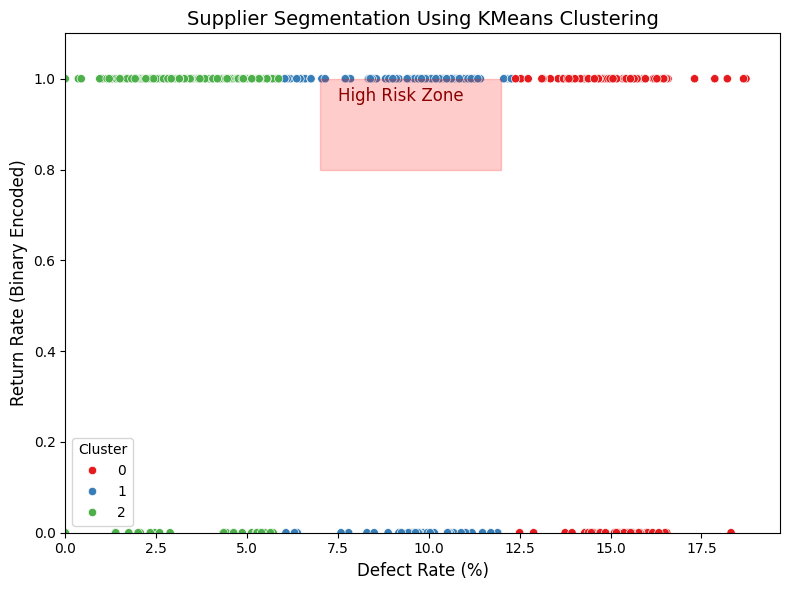

In [7]:
# -------------------------------
# Step 5: Visualization
# -------------------------------
# KMeans clustering plot
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(
    x='Defect Rate', y='Return Rate', hue='Cluster', data=df_plot, ax=ax, palette='Set1'
)
ax.add_patch(plt.Rectangle((7, 0.8), 5, 0.2, alpha=0.2, color='red'))  # Highlighting risky zone
ax.text(7.5, 0.95, 'High Risk Zone', color='darkred', fontsize=12)
ax.set_title('Supplier Segmentation Using KMeans Clustering', fontsize=14)
ax.set_xlabel('Defect Rate (%)', fontsize=12)
ax.set_ylabel('Return Rate (Binary Encoded)', fontsize=12)
ax.set_xlim(left=0)
ax.set_ylim(0, 1.1)
ax.legend(title='Cluster')

plt.tight_layout()
plt.show()

# Interpretation:
# This plot segments suppliers based on their defect rate and return rate.
# The red box marks suppliers with high defect rates (>7%) and return rates near 1, flagging them as potential high-risk sources.
# Clusters help differentiate supplier quality groups for targeted improvement strategies.


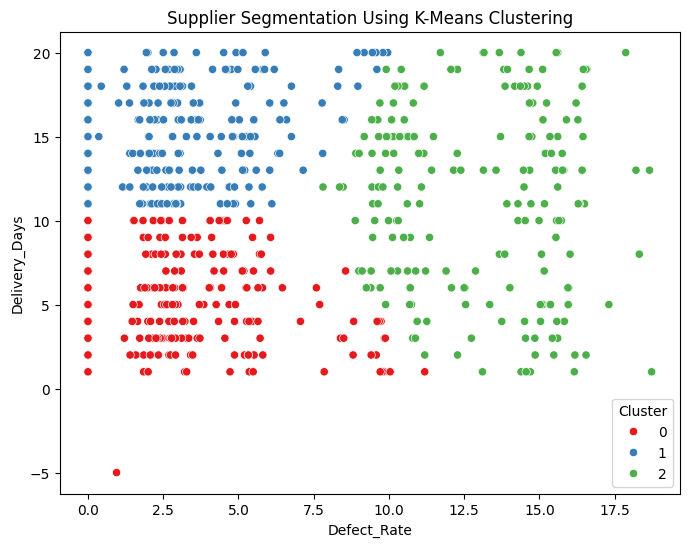

In [8]:
# K-Means clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = df[['Defect_Rate', 'Delivery_Days']].copy()
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(features_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Defect_Rate', y='Delivery_Days', hue='Cluster', palette='Set1')
plt.title('Supplier Segmentation Using K-Means Clustering')
plt.savefig("figure_kmeans.png", dpi=300)
plt.show()


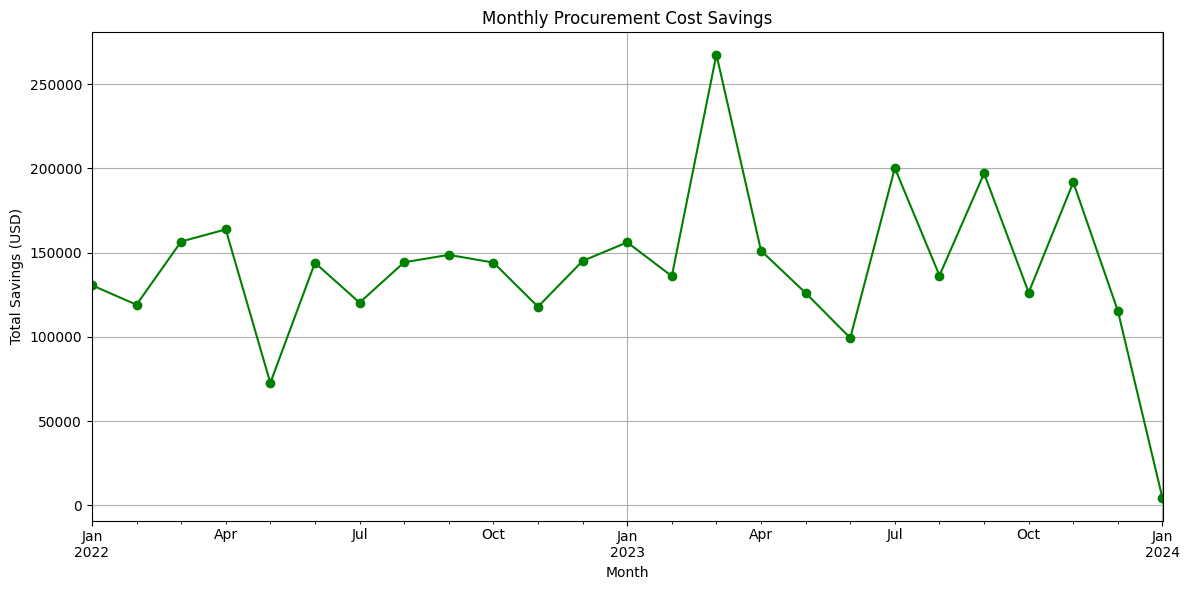

In [10]:
# Monthly Procurement Cost Saving

# Convert Order_Date to datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')

# Calculate Total Saving per PO
df['Total_Saving'] = (df['Unit_Price'] - df['Negotiated_Price']) * df['Quantity']

# Extract month and year from Order_Date
df['Order_Month'] = df['Order_Date'].dt.to_period('M')

# Group by month and calculate total savings
monthly_savings = df.groupby('Order_Month')['Total_Saving'].sum().sort_index()

# Plot the line chart
plt.figure(figsize=(12, 6))
monthly_savings.plot(kind='line', marker='o', color='green')
plt.title('Monthly Procurement Cost Savings')
plt.xlabel('Month')
plt.ylabel('Total Savings (USD)')
plt.grid(True)
plt.tight_layout()
plt.savefig("monthly_procurement_cost_savings.png")
plt.show()


Average Delivery Duration: 10.78 days
Median Delivery Duration: 11.0 days
Average Defect Rate: 5.79 %
Average Cost Saving per PO: 5091.66 USD
Total Cost Saving: 3513248.15 USD
Compliance Rate: 81.88 %


<Axes: title={'center': 'Monthly Purchase Order Volume'}, xlabel='Order_Month'>

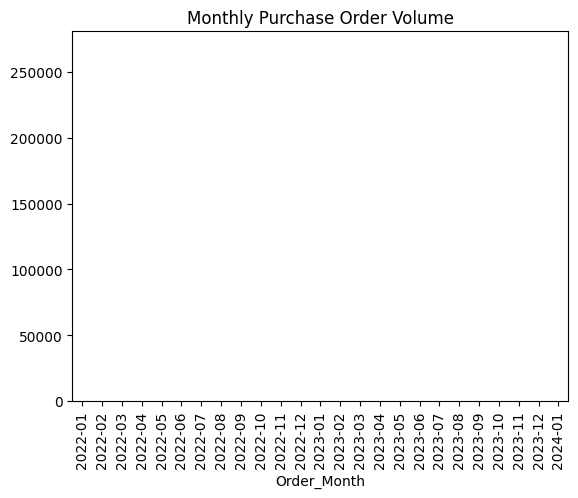

In [11]:

# Load and preprocess
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'], errors='coerce')
df['Delivery_Duration'] = (df['Delivery_Date'] - df['Order_Date']).dt.days
df['Defect_Rate'] = (df['Defective_Units'] / df['Quantity']) * 100
df['Total_Saving'] = (df['Unit_Price'] - df['Negotiated_Price']) * df['Quantity']
df['Order_Month'] = df['Order_Date'].dt.to_period('M')

# KPI summaries
print("Average Delivery Duration:", round(df['Delivery_Duration'].mean(), 2), "days")
print("Median Delivery Duration:", round(df['Delivery_Duration'].median(), 2), "days")
print("Average Defect Rate:", round(df['Defect_Rate'].mean(), 2), "%")
print("Average Cost Saving per PO:", round(df['Total_Saving'].mean(), 2), "USD")
print("Total Cost Saving:", round(df['Total_Saving'].sum(), 2), "USD")
print("Compliance Rate:", round((df['Compliance'] == 'Yes').mean() * 100, 2), "%")

# Monthly trends
monthly_savings = df.groupby('Order_Month')['Total_Saving'].sum()
monthly_delivery = df.groupby('Order_Month')['Delivery_Duration'].mean()
monthly_po_volume = df.groupby('Order_Month')['PO_ID'].count()

# Visualizations
monthly_savings.plot(title='Monthly Procurement Cost Savings')
monthly_delivery.plot(title='Average Delivery Duration Over Time')
monthly_po_volume.plot(kind='bar', title='Monthly Purchase Order Volume')


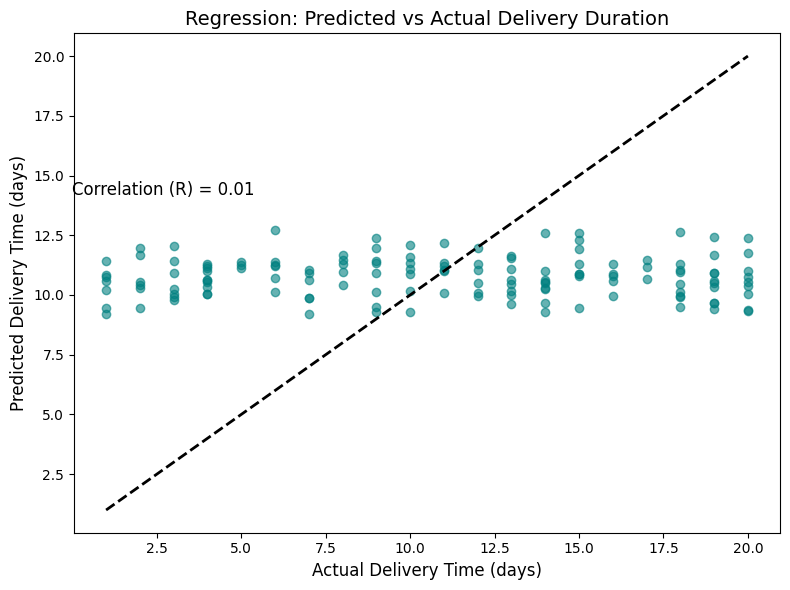

In [ ]:

# Regression: Actual vs Predicted Delivery Time
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(y_test, y_pred, alpha=0.6, color='teal')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
corr = np.corrcoef(y_test, y_pred)[0, 1]
ax.text(y_test.max() - 20, y_pred.min() + 5, f'Correlation (R) = {corr:.2f}', fontsize=12)
ax.set_title('Regression: Predicted vs Actual Delivery Duration', fontsize=14)
ax.set_xlabel('Actual Delivery Time (days)', fontsize=12)
ax.set_ylabel('Predicted Delivery Time (days)', fontsize=12)

plt.tight_layout()
plt.show()

# Interpretation:
# This plot compares the predicted delivery time (from the regression model) to the actual time.
# A strong diagonal alignment suggests good prediction accuracy.
# The correlation coefficient
# R indicates the strength of the linear relationship — values closer to 1.0 indicate better predictive power.

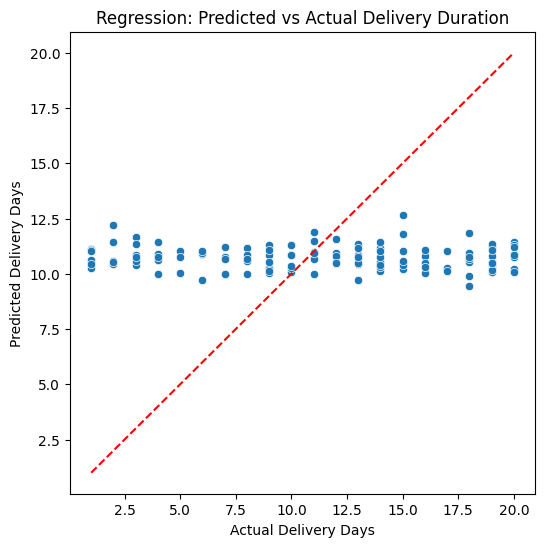

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df[['Quantity','Unit_Price','Negotiated_Price','Defect_Rate']]
y = df['Delivery_Days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Delivery Days')
plt.ylabel('Predicted Delivery Days')
plt.title('Regression: Predicted vs Actual Delivery Duration')
plt.savefig("figure_regression_pred_actual.png", dpi=300)
plt.show()


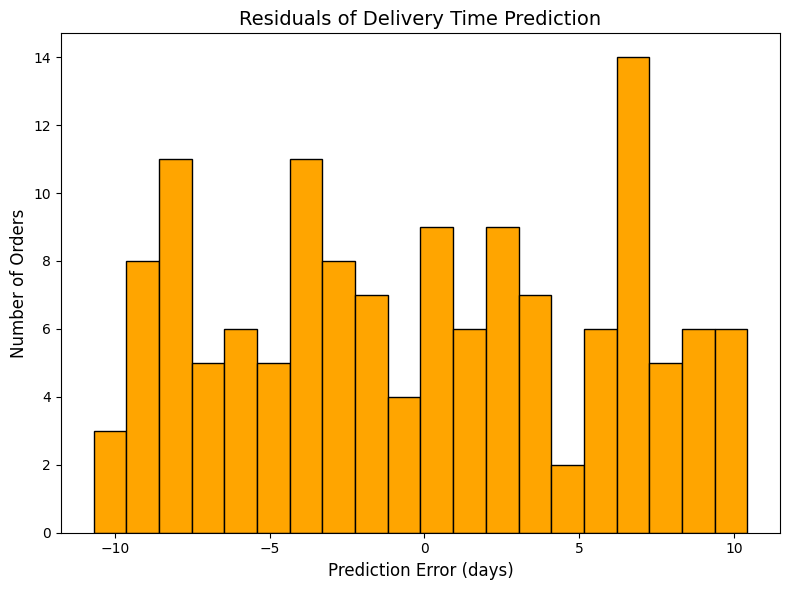

In [ ]:
# Residuals of Delivery Time Prediction
residuals = y_pred - y_test

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(residuals, bins=20, color='orange', edgecolor='black')
ax.set_title('Residuals of Delivery Time Prediction', fontsize=14)
ax.set_xlabel('Prediction Error (days)', fontsize=12)
ax.set_ylabel('Number of Orders', fontsize=12)

plt.tight_layout()
plt.show()

# Interpretation:
# This histogram shows how far predictions deviate from actual delivery times.
# A symmetric distribution centered around zero means the model makes unbiased predictions.
# Wider spread indicates higher variance and suggests potential for improvement.


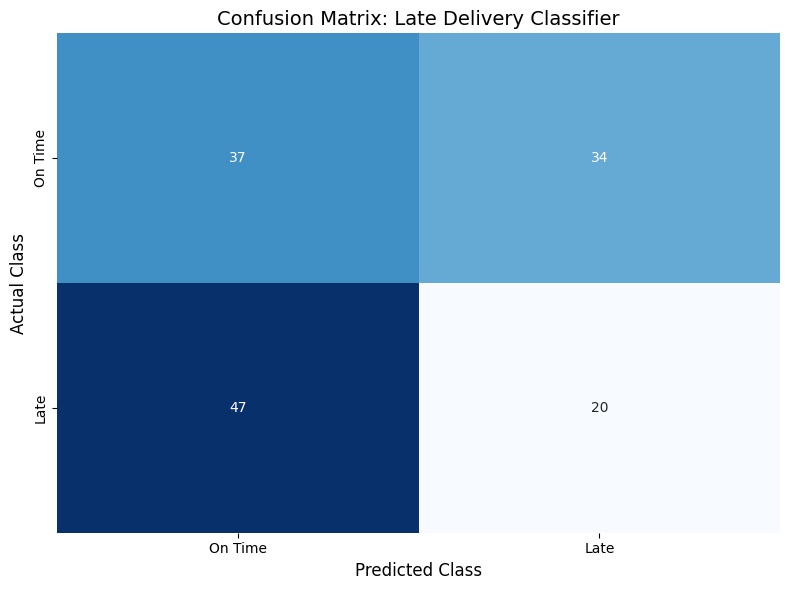

In [ ]:
# Confusion Matrix for Late Delivery Classifier
fig, ax = plt.subplots(figsize=(8, 6))

cm = confusion_matrix(y_true_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
ax.set_title('Confusion Matrix: Late Delivery Classifier', fontsize=14)
ax.set_xlabel('Predicted Class', fontsize=12)
ax.set_ylabel('Actual Class', fontsize=12)
ax.set_xticklabels(['On Time', 'Late'])
ax.set_yticklabels(['On Time', 'Late'])

plt.tight_layout()
plt.show()

# Interpretation:
# The confusion matrix evaluates your logistic regression classifier that predicts whether a delivery is late or on time.

# True Positives (bottom-right): Late deliveries correctly identified.

# True Negatives (top-left): On-time deliveries correctly classified.

# Misclassifications appear off-diagonal and suggest opportunities to improve model accuracy.



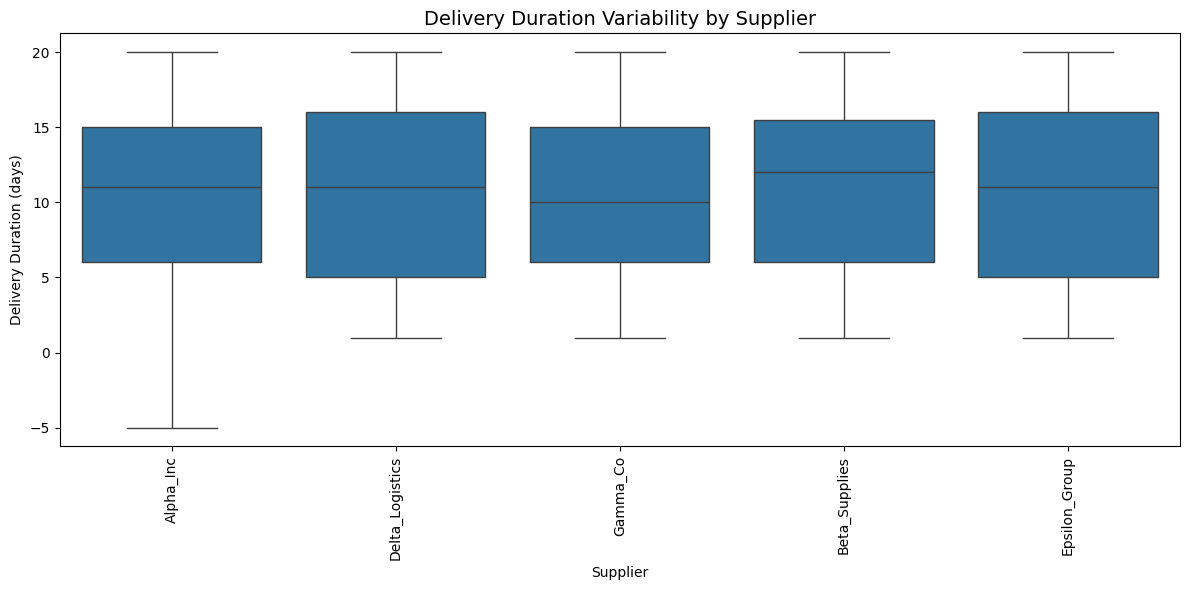

In [ ]:
# Boxplots for Delivery Variability Across Suppliers
plt.figure(figsize=(12, 6))
sns.boxplot(x='Supplier', y='Delivery_Duration', data=df_model)
plt.title('Delivery Duration Variability by Supplier', fontsize=14)
plt.xlabel('Supplier')
plt.ylabel('Delivery Duration (days)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Interpretation:
# This boxplot shows delivery consistency per supplier.

# Tall boxes (high IQR) indicate inconsistent performance.

# Dots beyond whiskers are outliers (late deliveries).
# Such suppliers may pose logistical risks and require contract revision or escalation.

In [ ]:
print(df_model.columns.tolist())

['PO_ID', 'Supplier', 'Order_Date', 'Delivery_Date', 'Item_Category', 'Order_Status', 'Quantity', 'Unit_Price', 'Negotiated_Price', 'Defective_Units', 'Return Rate', 'Delivery_Days', 'Defect_Rate', 'Cost_Saving_Per_Unit', 'Total_Saving', 'On_Time', 'High_Defect', 'Non_Compliance', 'High_Risk_Supplier', 'Delivery_Duration', 'Defect Rate', 'Late']


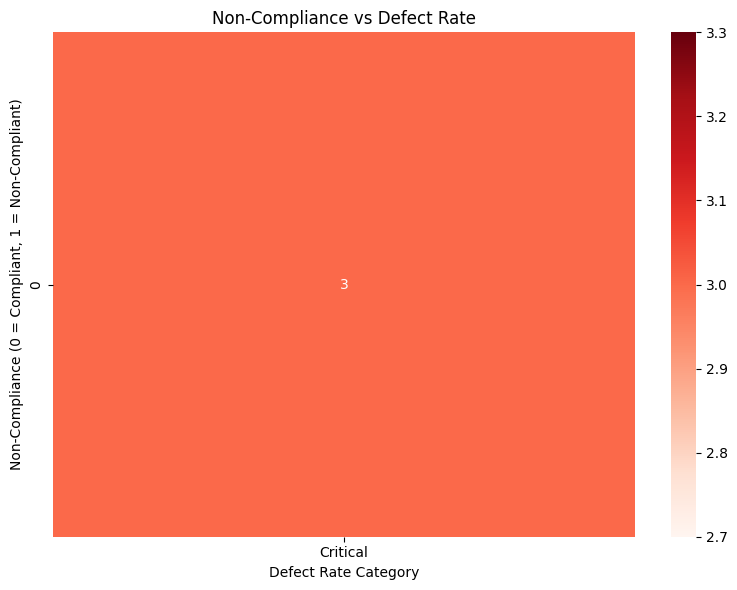

In [ ]:
#Heatmap: Non-Compliance vs Defect Rate

# Create bins for Defect Rate
df_model['Defect_Rate_Bin'] = pd.cut(df_model['Defect Rate'], bins=[0, 0.05, 0.10, 0.20, 1.0], labels=['Low', 'Moderate', 'High', 'Critical'])

# Crosstab for Heatmap
compliance_defect_ct = pd.crosstab(df_model['Non_Compliance'], df_model['Defect_Rate_Bin'])

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(compliance_defect_ct, annot=True, cmap='Reds', fmt='d')
plt.title('Non-Compliance vs Defect Rate')
plt.xlabel('Defect Rate Category')
plt.ylabel('Non-Compliance (0 = Compliant, 1 = Non-Compliant)')
plt.tight_layout()
plt.show()



# Interpretation:
# This heatmap reveals how often non-compliant suppliers fall into higher defect rate categories. Clusters of high values in the upper rows and rightmost bins indicate suppliers who both fail compliance and deliver low-quality products.

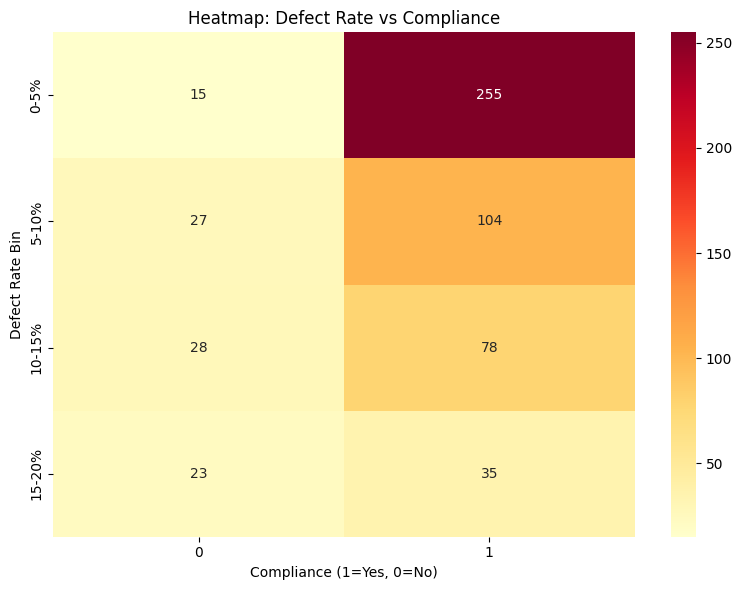

In [13]:

df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'], errors='coerce')

# Calculate Delivery Duration
df['Delivery_Duration'] = (df['Delivery_Date'] - df['Order_Date']).dt.days

# Calculate Defect Rate
df['Defect_Rate'] = (df['Defective_Units'] / df['Quantity']) * 100

# Map Compliance to binary
df['Compliance_Binary'] = df['Compliance'].map({'Yes': 1, 'No': 0})

# Drop rows with missing values
df_clean = df.dropna(subset=['Defect_Rate', 'Delivery_Duration', 'Compliance_Binary'])

# Bin Defect Rate and Delivery Duration
df_clean['Defect_Bin'] = pd.cut(df_clean['Defect_Rate'], bins=[0, 5, 10, 15, 20, 100], labels=['0-5%', '5-10%', '10-15%', '15-20%', '20%+'])
df_clean['Delivery_Bin'] = pd.cut(df_clean['Delivery_Duration'], bins=[0, 5, 10, 15, 20, 100], labels=['0-5d', '5-10d', '10-15d', '15-20d', '20d+'])

# Heatmap: Defect Rate vs Compliance
defect_compliance = pd.crosstab(df_clean['Defect_Bin'], df_clean['Compliance_Binary'])
plt.figure(figsize=(8, 6))
sns.heatmap(defect_compliance, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Heatmap: Defect Rate vs Compliance')
plt.xlabel('Compliance (1=Yes, 0=No)')
plt.ylabel('Defect Rate Bin')
plt.tight_layout()
plt.savefig("heatmap_defect_vs_compliance.png")
plt.show()



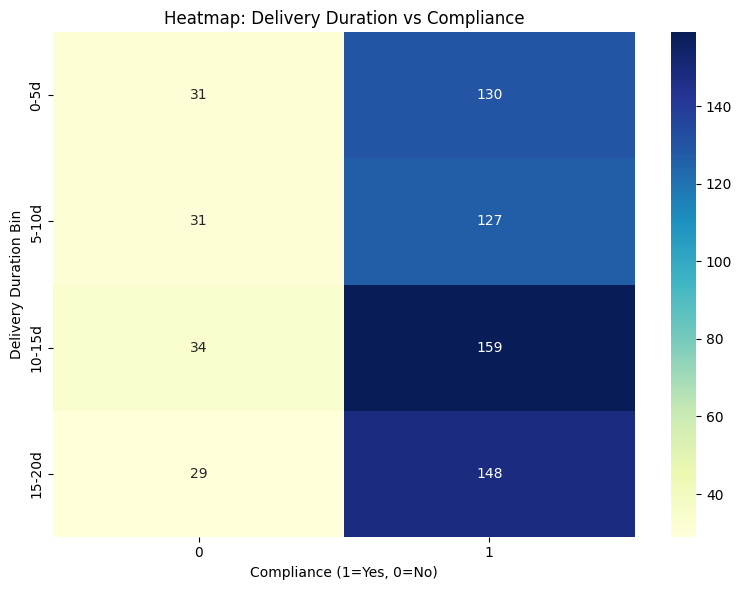

In [14]:
# Heatmap: Delivery Duration vs Compliance
delivery_compliance = pd.crosstab(df_clean['Delivery_Bin'], df_clean['Compliance_Binary'])
plt.figure(figsize=(8, 6))
sns.heatmap(delivery_compliance, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap: Delivery Duration vs Compliance')
plt.xlabel('Compliance (1=Yes, 0=No)')
plt.ylabel('Delivery Duration Bin')
plt.tight_layout()
plt.savefig("heatmap_delivery_vs_compliance.png")
plt.show()

/tmp/ipython-input-567098969.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_savings = df_model.resample('M', on='Order_Date')['Savings'].sum()


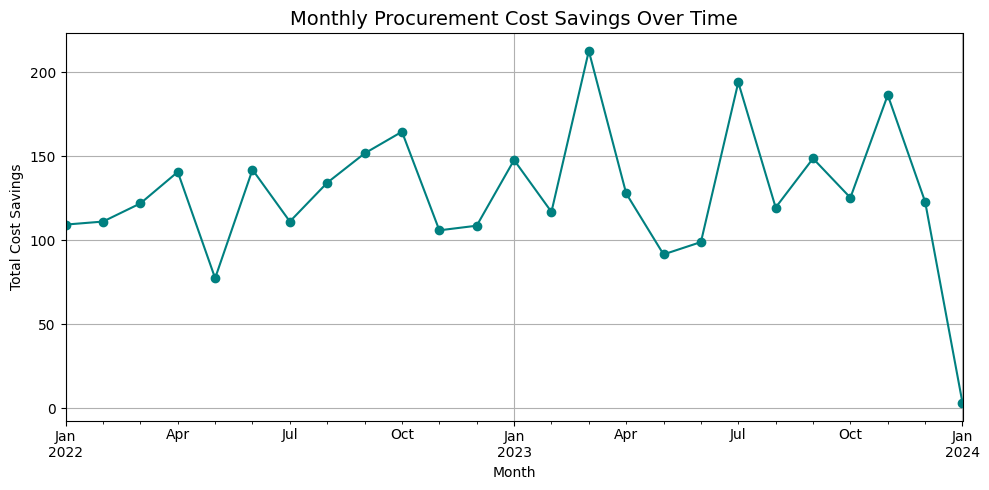

In [ ]:
# Time Series for Procurement Cost Savings
df_model['Order_Date'] = pd.to_datetime(df_model['Order_Date'])
df_model['Savings'] = df_model['Unit_Price'] - df_model['Negotiated_Price']

monthly_savings = df_model.resample('M', on='Order_Date')['Savings'].sum()

plt.figure(figsize=(10, 5))
monthly_savings.plot(marker='o', linestyle='-', color='teal')
plt.title('Monthly Procurement Cost Savings Over Time', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Total Cost Savings')
plt.grid(True)
plt.tight_layout()
plt.show()

# Interpretation:
# This time series shows cost savings from negotiations over time.

# Rising trends reflect procurement efficiency.

# Sudden drops may point to weak negotiation leverage or market issues.

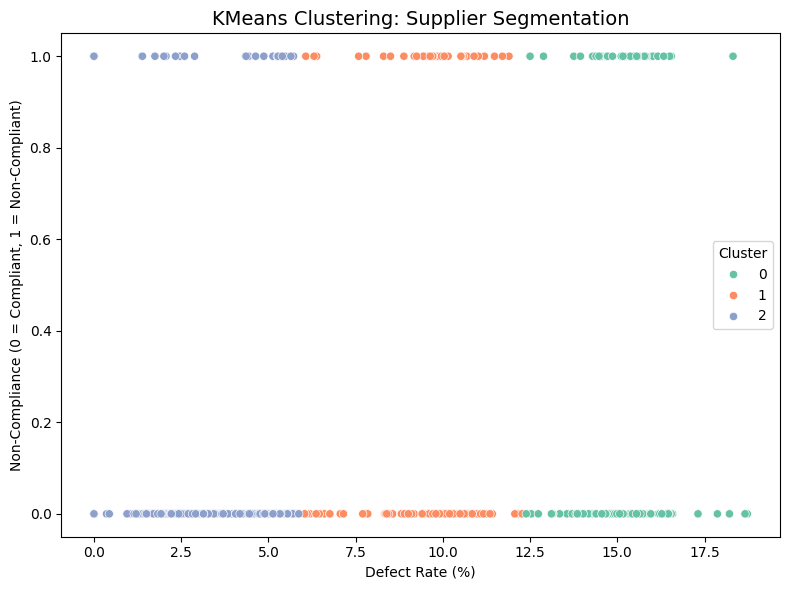

In [ ]:
# Cluster Visualization: KMeans on Defect & Compliance
from sklearn.cluster import KMeans

# Select relevant columns and drop missing values
df_cluster = df_model[['Defect Rate', 'Non_Compliance']].dropna()

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)
df_cluster['Cluster'] = kmeans.fit_predict(df_cluster[['Defect Rate', 'Non_Compliance']])

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cluster, x='Defect Rate', y='Non_Compliance', hue='Cluster', palette='Set2')
plt.title('KMeans Clustering: Supplier Segmentation', fontsize=14)
plt.xlabel('Defect Rate (%)')
plt.ylabel('Non-Compliance (0 = Compliant, 1 = Non-Compliant)')
plt.tight_layout()
plt.show()

# Interpretation:
# The scatter plot shows supplier clusters based on defect rates and compliance.
# Clusters likely correspond to groups with low, medium, and high risk profiles.
# These insights can inform supplier management strategies.





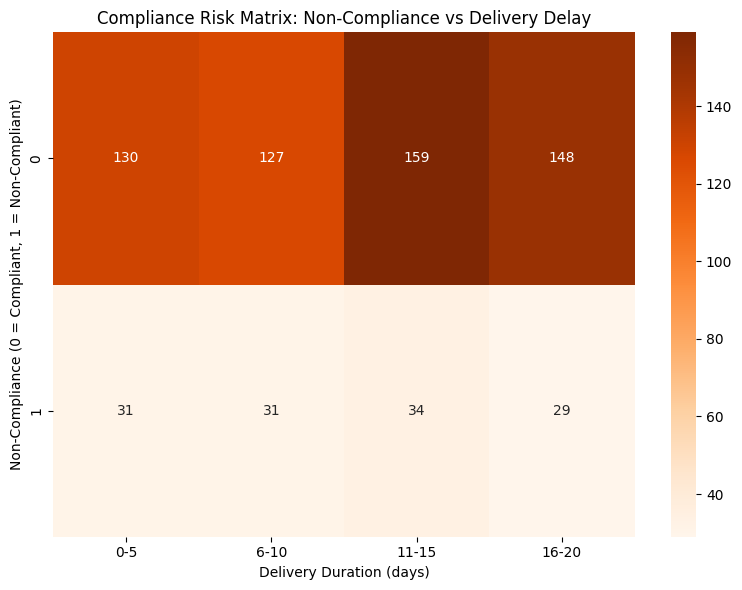

In [ ]:
# Compliance Risk Matrix (Heatmap)

# Bin delivery duration
df_model['Delay_Bin'] = pd.cut(df_model['Delivery_Duration'], bins=[0, 5, 10, 15, 20, 100],
                               labels=['0-5','6-10','11-15','16-20','20+'])

# Create crosstab using Non_Compliance instead of Compliance_Binary
risk_matrix = pd.crosstab(df_model['Non_Compliance'], df_model['Delay_Bin'])

plt.figure(figsize=(8, 6))
sns.heatmap(risk_matrix, annot=True, cmap="Oranges", fmt='d')
plt.title('Compliance Risk Matrix: Non-Compliance vs Delivery Delay')
plt.xlabel('Delivery Duration (days)')
plt.ylabel('Non-Compliance (0 = Compliant, 1 = Non-Compliant)')
plt.tight_layout()
plt.show()


# Interpretation:
# This heatmap cross-tabulates non-compliance status with delivery delay categories.

#   Suppliers with a Non_Compliance value of 1 and longer delivery delays (rightmost columns) are the highest risk for operational and regulatory issues.

#   This helps prioritize supplier remediation efforts.


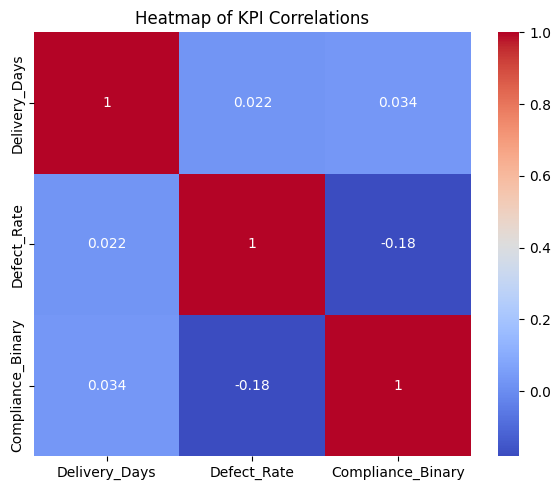

In [15]:

corr_matrix = df_clean[['Delivery_Days', 'Defect_Rate', 'Compliance_Binary']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Heatmap of KPI Correlations")
plt.tight_layout()
plt.savefig("heatmap_kpi_correlations.png")
plt.show()


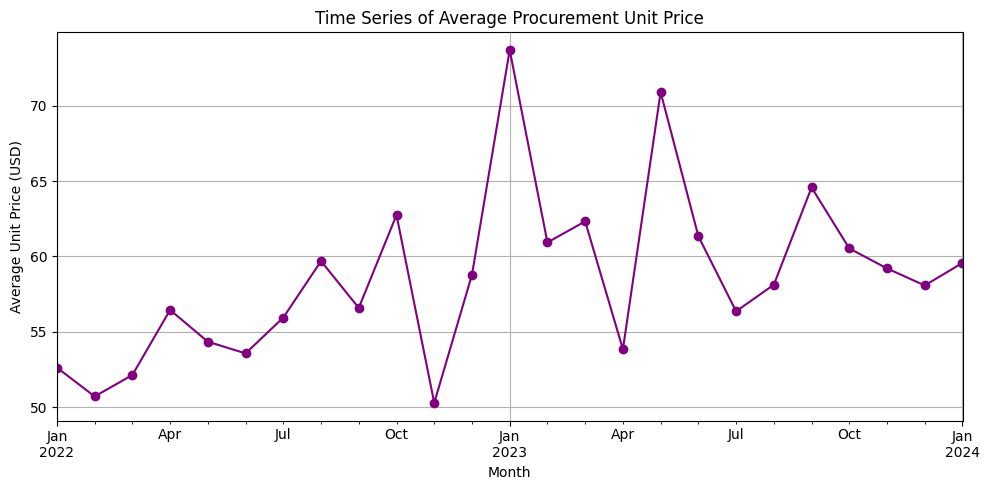

In [16]:
monthly_price = df_clean.groupby('Order_Month')['Unit_Price'].mean()
plt.figure(figsize=(10, 5))
monthly_price.plot(marker='o', color='purple')
plt.title("Time Series of Average Procurement Unit Price")
plt.xlabel("Month")
plt.ylabel("Average Unit Price (USD)")
plt.grid(True)
plt.tight_layout()
plt.savefig("time_series_unit_price.png")
plt.show()


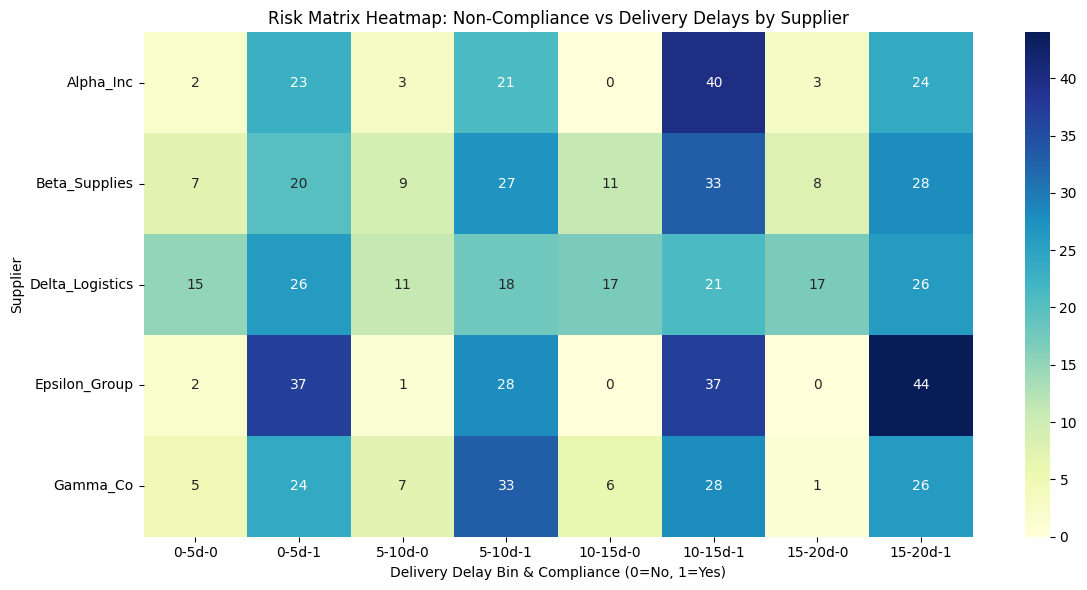

In [17]:
df_clean['Delivery_Bin'] = pd.cut(df_clean['Delivery_Days'], bins=[0, 5, 10, 15, 20, 100], labels=['0-5d', '5-10d', '10-15d', '15-20d', '20d+'])
risk_matrix = pd.crosstab(df_clean['Supplier'], [df_clean['Delivery_Bin'], df_clean['Compliance_Binary']])
plt.figure(figsize=(12, 6))
sns.heatmap(risk_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Risk Matrix Heatmap: Non-Compliance vs Delivery Delays by Supplier")
plt.xlabel("Delivery Delay Bin & Compliance (0=No, 1=Yes)")
plt.ylabel("Supplier")
plt.tight_layout()
plt.savefig("risk_matrix_heatmap.png")
plt.show()


## Step 6: Save Output (Simulated)

In [ ]:
# Save locally (in production: upload tocloud)
output_folder = '/content/drive/My Drive/w2089144_CW_Adv_Big_Data/Dataset/'

# Save the files into that folder
df.to_csv(output_folder + 'enriched_procurement_kpi_analysis_dataset.csv', index=False)
summary.to_csv(output_folder + 'supplier_summary.csv', index=False)

## ✅ Covered Areas
- Delivery Delays → `Delivery_Days`, `On_Time`
- Defect Risks → `Defect_Rate`, `High_Defect`
- Cost Inefficiencies → `Cost_Saving_Per_Unit`, `Total_Saving`
- Compliance Violations → `Non_Compliance`
- Supplier Risk → `High_Risk_Supplier`
- Supplier Evaluation → `summary` table